<a href="https://colab.research.google.com/github/monikamikhaiel/graduation-project-/blob/main/AntennaPositionning%2B_heat_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np  # for array stuff and random
import matplotlib.pyplot as plt  # for graphing our mean rewards over time
from matplotlib.pyplot import figure
from matplotlib import style  # to make pretty charts because it matters.
import time  # using this to keep track of our saved Q-Tables.
style.use("ggplot")  # setting our style!

In [14]:
#the size of the area 
SIZE_W = int(input("please enter the width of the building in meter :"))
SIZE_H = int(input("please enter the height of the building in meter :"))
print(SIZE_H,SIZE_W)


please enter the width of the building in meter :5
please enter the height of the building in meter :5
5 5


In [15]:
HM_EPISODES = 2500
epsilon = 0.5  # randomness
EPS_DECAY = 0.9999  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 100  # how often to play through env visually.

start_q_table = None  # if we have a pickled Q table, we'll put the filename of it here.

LEARNING_RATE = 0.1
DISCOUNT = 0.95

ANTENNA_N = 1  # player key in dict

#SNR RANGES
snr_range={"highSNR_max":-50,"highSNR_min":-80,
           "mediumSNR_max":-90,"mediumSNR_min":-100,
          "deadzone":-120}


In [16]:
#antenna
class antenna:
    def __init__(self,x_,y_):
      if not x_:
        self.x = np.random.randint(0, SIZE_W)
      else:
        self.x=x_
      if not y_:
        self.y = np.random.randint(0, SIZE_H)
      else:
        self.y=y_
        
        
    def __str__(self):
        return f"{self.x}, {self.y}"
    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)
    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3)
        '''
        if choice == 0:  #up
            #self.move(x=0, y=1)
            self.x=self.x
            self.y+=1
            self.move()

        elif choice == 1:  #down
            #self.move(x=0, y=-1)
            self.x=self.x
            self.y-=1
            self.move()

        elif choice == 2:  #left
           # self.move(x=-1, y=0)
            self.x-=1
            self.y=self.y
            self.move()

        elif choice == 3:    #right
            # self.move(x=1, y=0)
            self.x+=1
            self.y=self.y
            self.move()

#    def move(self, x=False, y=False):
    def move(self):
        # If no value for x, move randomly
      #  if not x:
      #      self.x += np.random.randint(-1, 2)
       # elif x==0:
      #      self.x=self.x
      #  else:
       #     self.x += x

        # If no value for y, move randomly
       # if not y:
        #    self.y += np.random.randint(-1, 2)
       # elif y==0:
        #    self.y=self.y
       # else:
        #    self.y += y
      # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE_W-1:
            self.x = SIZE_W-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE_H-1:
            self.y = SIZE_H-1



In [17]:
ant = antenna(2,3)
print(ant)
ant.action(0) # up
print(ant)
ant.action(1) #down 
print(ant)
ant.action(2) #left
print(ant)
ant.action(3) #right 
print(ant)


2, 3
2, 4
2, 3
1, 3
2, 3


In [18]:
#build the initial q table 
x = SIZE_W # Building X
y = SIZE_H # Building Y
z = 4 # actions

q_table = np.zeros((x, y, z))
# q_table *= 0
print(q_table.shape)


(5, 5, 4)


In [19]:
#okomora model 
def okomora(ant,SIZE_H,SIZE_W):
  PathLoss=[]
  attenuation= 13 #in db function of frequency and distance 
  freq= 2.4*(10^9) # the frequency og the signal
  c= 3*(10^8) # the speed of light
  #hte = input("please enter the height of the transmitter antenna ? ")
  #hre = input("please enter the height of the receiver antenna ? ")
  hte= 20
  hre= 2
  G_hte = 10*np.log(int(hte) /200) 
  G_hre = 10*np.log(int(hre)/ 3)
  G_Area =27 # (Quasi Open Area)
  for i in range(SIZE_H):
    for j in range(SIZE_W):
      difference = [ant.x-i,ant.y-j]
      if difference == [0,0]:
        continue
      else:
        ## calculate the pathloss
        distance=pow((pow(difference[0],2)+pow(difference[1],2)),0.5)
        FPL      = 20*np.log(4*np.pi*distance*freq/c)
        Path_Loss = FPL + attenuation - G_hte - G_hre - G_Area
        PathLoss.append(Path_Loss)
  return PathLoss  
#len(okomora(ant,SIZE_H,SIZE_W))

In [20]:
def AnglesInDegrees(ant,SIZE_H,SIZE_W):
  theta=[]
  for i in range(SIZE_H):
    for j in range(SIZE_W):
      difference = [ant.x-i,ant.y-j]
      if difference==[0,0]: # the same position as the antenna 
        continue
      if difference[0]==0:     # the angle itself is either 90 or 270 tan will be infinite 
          if difference[1]>0:
            t=90
            theta.append(90)
          else:
            t=270
            theta.append(270)
      else:
          tantheta= difference[1]/difference[0]
          t=np.degrees(np.arctan(tantheta))
          if t <=0:
            t+=360
            theta.append(t)
          else:
            theta.append(t)
  return theta
#print(len(AnglesInDegrees(ant,SIZE_H,SIZE_W)))

In [21]:
def measureSNR(ant,SIZE_H,SIZE_W,typeOfAntenna="omnidirectionnel"):
  Path_Loss=okomora(ant,SIZE_H,SIZE_W)
  Gain=[]
  if typeOfAntenna == "omnidirectionnel" :
    Gain_pannel=7 #in db
    for i in range(len(Path_Loss)):
      Gain.append(Gain_pannel-Path_Loss[i])
  elif typeOfAntenna== "directionnel":
    thetas=AnglesInDegrees(ant,SIZE_H,SIZE_W)
    gain=7 #db
    for i in range(len(Path_Loss)):
      Gain.append((gain*np.cos(thetas[i]))-Path_Loss[i])
  else:
    thetas=AnglesInDegrees(ant,SIZE_H,SIZE_W)
    GainVsTheta={360:-20,30:-10,60:-5,90:15,120:0,150:-10,180:-20,210:-10,240:-8,270:-15,300:-8,330:-10} # values in db angle:gain
    for i in range(len(thetas)):
      t=thetas[i]
      if t==0:
       value = GainVsTheta[360]
      elif t<=30:
        value = GainVsTheta[30]
      elif 30<t<=60:
        value = GainVsTheta[60]
      elif 60<t<=90:
        value = GainVsTheta[90]
      elif 90<t<=120:
        value = GainVsTheta[120]
      elif 120<t<=150:
        value = GainVsTheta[150]
      elif 150<t<=180:
        value = GainVsTheta[180]
      elif 180<t<=210:
        value = GainVsTheta[210]
      elif 210<t<=240:
        value = GainVsTheta[240]
      elif 240<t<=270:
        value = GainVsTheta[270]
      elif 270<t<=300:
        value = GainVsTheta[300]
      elif 300<t<=330:
        value = GainVsTheta[330]
      elif 330<t<=360:
        value = GainVsTheta[360]
      Gain.append(value-Path_Loss[i])
  Magnitude=[]
  # from db to magnitude 
  for g in Gain:
    mag=pow(10,(g/10))
    Magnitude.append(mag)
  return Magnitude
#measureSNR(ant,SIZE_H,SIZE_W,type="omnidirectionnel")


In [22]:
def calSNRlow(SNR,TypeOfReward):
    if TypeOfReward=="AverageSNR":
      return np.mean(SNR)
    else:
      counter =0
      for i in range(len(SNR)):
            if int(SNR[i]) < snr_range["deadzone"]:
              counter+=1
      percent=counter*100/len(SNR)
    return percent
    

calSNRlow(measureSNR (ant,SIZE_H,SIZE_W),TypeOfReward="AverageSNR")

1.9693035320699446e-07

In [25]:
def TrainingAgent(HM_EPISODES=HM_EPISODES,EPS_DECAY=EPS_DECAY,LEARNING_RATE=LEARNING_RATE,DISCOUNT=DISCOUNT,epsilon=epsilon,
                  SIZE_H=SIZE_H,SIZE_W=SIZE_W,typeOfAntenna="omnidirectionnel",TypeOfReward="AverageSNR"):
  episode_rewards = []
  reward=0
  for episode in range(HM_EPISODES):
      x_=np.random.randint(0, SIZE_H)
      y_=np.random.randint(0, SIZE_W)
      ant = antenna(x_,y_)
      if episode % SHOW_EVERY == 0:
          print(f"on #{episode}")
       # print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
          show = True
      else:
          show = False

      episode_reward = 0
      for i in range(200):
          antennaPos = (ant) # Current Antenna X, Y Co-ord.
         # choose an action 
          if np.random.random() > epsilon: 
              action = np.argmax(q_table[ant.x][ant.y])
          else:
              action = np.random.randint(0, 4) #low is inclusive high is exclusive 
            #print(action)
        # Take the action!
          ant.action(action) # move the  antenna
        ###
        #calculate the SNR
          snr=measureSNR(ant,SIZE_H,SIZE_W,typeOfAntenna="omnidirectionnel")
          percent=calSNRlow(snr,TypeOfReward=TypeOfReward)
        ##
          reward=percent
          ###
        #current_q = q_table[state][action]
          newAntennaPos = (ant)
          current_q = q_table[ant.x][ant.y][action] # Current State
          max_future_q = np.max(q_table[ant.x][ant.y]) # Max State
          new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
          q_table[ant.x][ant.y][action] = new_q
      

          episode_reward += reward

        #print(episode_reward)
      episode_rewards.append(episode_reward)
      epsilon *= EPS_DECAY
  return q_table

In [ ]:
q_table=TrainingAgent(HM_EPISODES=HM_EPISODES,EPS_DECAY=EPS_DECAY,LEARNING_RATE=LEARNING_RATE,DISCOUNT=DISCOUNT,epsilon=epsilon,
                  SIZE_H=SIZE_H,SIZE_W=SIZE_W,typeOfAntenna="omnidirectionnel",TypeOfReward="AverageSNR")

4.004103383034576e-06


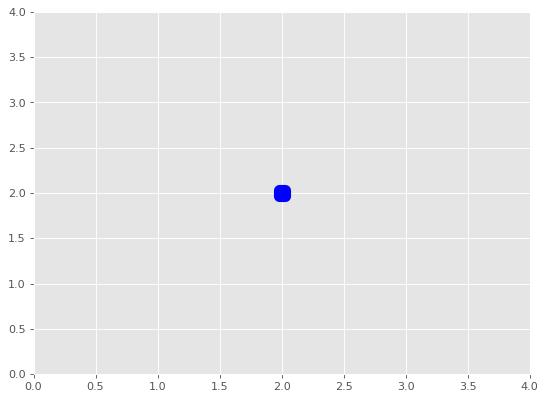

In [31]:
#plot the result of the agent 
xval=[]
yval=[]
max_value =np.max((q_table))
print(max_value)
for i in range(SIZE_H):
    for j in range(SIZE_W):
      for k in range(4):
        if max_value  == (q_table[i][j][k]):
            xval.append(i)
            yval.append(j)
        else :
            continue
figure(figsize=(8, 6), dpi=80) # increase figure size 
plt.scatter(xval, yval, color= "blue", linewidths =10 ,marker ="s")
plt.xlim(0, SIZE_H-1)
plt.ylim(0, SIZE_W-1)
plt.show()
#print(q_table)
#print(xval)


#looping on q_table 
#antenna Tracing qtable 
AntTest2=antenna(2,3)
AntTest2.x=xval[0]
AntTest2.y=yval[0]
for i in range(10):
  print(AntTest2)
  actionx = np.argmax(q_table[AntTest2.x][AntTest2.y])
  print(actionx)
  AntTest2.action(actionx)
  #plt.scatter(AntTest2.x,AntTest2.y, color= "blue", linewidths =2 ,marker ="s")
  #plt.xlim(0, 4)
  #plt.ylim(0, 4)
  #plt.show()


In [35]:
#looping on the area 
#brute force check  get the optimal decision 
AntTest=antenna(2,3)
EveryWhere={}
max=-200
#Move antenna Every where 
for i in range(SIZE_H):
  for j in range(SIZE_W):
    AntTest.x =i
    AntTest.y = j
    AvgSnr=calSNRlow(measureSNR(AntTest,SIZE_H,SIZE_W,typeOfAntenna="omnidirectionnel"),TypeOfReward="AverageSNR")
    if AvgSnr>max:
      max=AvgSnr
    list_=[AntTest.x,AntTest.y,AvgSnr]
    EveryWhere[AvgSnr]=[AntTest.x,AntTest.y]
print(max,EveryWhere[max])
print(EveryWhere)
## x,y,meanSNR   

2.002051691578497e-07 [2, 2]
{9.160583043925769e-08: [4, 4], 1.3886250977364017e-07: [4, 3], 1.412388049787932e-07: [4, 2], 9.160583043925767e-08: [4, 0], 1.3886250977364015e-07: [1, 0], 1.9381590820755185e-07: [3, 1], 1.9693035320699446e-07: [3, 2], 1.4123880497879323e-07: [2, 4], 2.002051691578497e-07: [2, 2], 1.938159082075519e-07: [3, 3]}


In [36]:
import pandas as pd
import seaborn as sns
# sns.set()

ant=antenna(xval[0],yval[0])
ArrayOfSNR=measureSNR(ant,SIZE_H,SIZE_W,typeOfAntenna="omnidirectionnel")
# convert from linear to db
snr_db=[] 
for SNR in (ArrayOfSNR):
  out_=10*np.log10(SNR)
  snr_db.append(out_)
print(snr_db)
# Build data
max_value_snr=np.max(snr_db)
min_value_snr=np.min(snr_db)
print(max_value_snr)
print(min_value_snr)

[-81.14183350308535, -76.441797210628, -74.21036169748591, -76.441797210628, -81.14183350308535, -76.441797210628, -67.27888989188646, -60.34741808628699, -67.27888989188646, -76.441797210628, -74.21036169748591, -60.34741808628699, -60.34741808628699, -74.21036169748591, -76.441797210628, -67.27888989188646, -60.34741808628699, -67.27888989188646, -76.441797210628, -81.14183350308535, -76.441797210628, -74.21036169748591, -76.441797210628, -81.14183350308535]
-60.34741808628699
-81.14183350308535


24


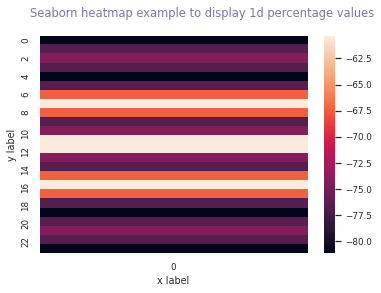

In [39]:
## 1D heatmap
plt.figure()
plt.suptitle("Seaborn heatmap example to display 1d percentage values", color='m')
sns.set(font_scale=0.8)

print(len(snr_db))
snr_db=np.reshape(snr_db,((SIZE_H*SIZE_W-1),1)) ## size_w*size_h -1
ax = sns.heatmap(snr_db, vmin=min_value_snr, vmax=max_value_snr)
ax.set(xlabel='x label', ylabel='y label')

plt.show()

In [40]:
#create 2D heatmap
rows=[]
row=[]
#print(type(snr_db[0]))
# insert a value
position=(SIZE_H*xval[0])+ yval[0]
snr_db_=np.insert(snr_db,position,[0])
print(snr_db_)
for j in range(SIZE_W):
  for i in range (SIZE_H):
    value=snr_db_[i+(SIZE_W)*j].astype(int)
    row.append(value)
  rows.append(row)
  row=[]
print(rows) 


[-81.1418335  -76.44179721 -74.2103617  -76.44179721 -81.1418335
 -76.44179721 -67.27888989 -60.34741809 -67.27888989 -76.44179721
 -74.2103617  -60.34741809   0.         -60.34741809 -74.2103617
 -76.44179721 -67.27888989 -60.34741809 -67.27888989 -76.44179721
 -81.1418335  -76.44179721 -74.2103617  -76.44179721 -81.1418335 ]
[[-81, -76, -74, -76, -81], [-76, -67, -60, -67, -76], [-74, -60, 0, -60, -74], [-76, -67, -60, -67, -76], [-81, -76, -74, -76, -81]]


<Figure size 432x288 with 0 Axes>

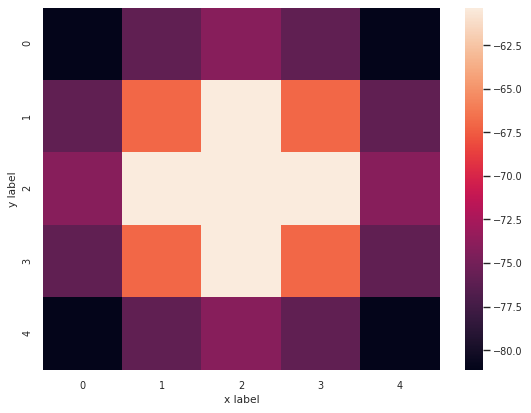

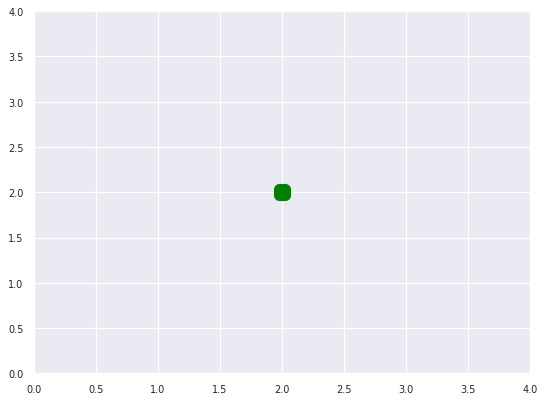

In [42]:
#2D heatmap
plt.figure()
plt.suptitle("Seaborn heatmap example to display 2d percentage values", color='m')
sns.set(font_scale=0.8)

#print(type(rows))
figure(figsize=(8, 6), dpi=80) # increase figure size 
rows_db=np.reshape(rows,(SIZE_H,SIZE_W))
ax = sns.heatmap(rows_db, vmin=min_value_snr, vmax=max_value_snr)
ax.set(xlabel='x label', ylabel='y label')


plt.show()
figure(figsize=(8, 6), dpi=80) # increase figure size 
plt.scatter(xval, yval, color= "green", linewidths =10 ,marker ="s")
plt.xlim(0, SIZE_H-1)
plt.ylim(0, SIZE_W-1)
plt.show()